In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("phileinsophos/predict-loan-amount-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/predict-loan-amount-data


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv(os.path.join(path, "train.csv"))


print("df shape:", df.shape)
print(df.head())

print(df.info())
print(df.describe())

df.columns


df shape: (30000, 24)
  Customer ID               Name Gender  Age  Income (USD) Income Stability  \
0     C-36995   Frederica Shealy      F   56       1933.05              Low   
1     C-33999  America Calderone      M   32       4952.91              Low   
2      C-3770      Rosetta Verne      F   65        988.19             High   
3     C-26480         Zoe Chitty      F   65           NaN             High   
4     C-23459       Afton Venema      F   31       2614.77              Low   

  Profession     Type of Employment    Location  Loan Amount Request (USD)  \
0    Working            Sales staff  Semi-Urban                   72809.58   
1    Working                    NaN  Semi-Urban                   46837.47   
2  Pensioner                    NaN  Semi-Urban                   45593.04   
3  Pensioner                    NaN       Rural                   80057.92   
4    Working  High skill tech staff  Semi-Urban                  113858.89   

   ...  Credit Score No. of Defaul

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price', 'Loan Sanction Amount (USD)'],
      dtype='object')

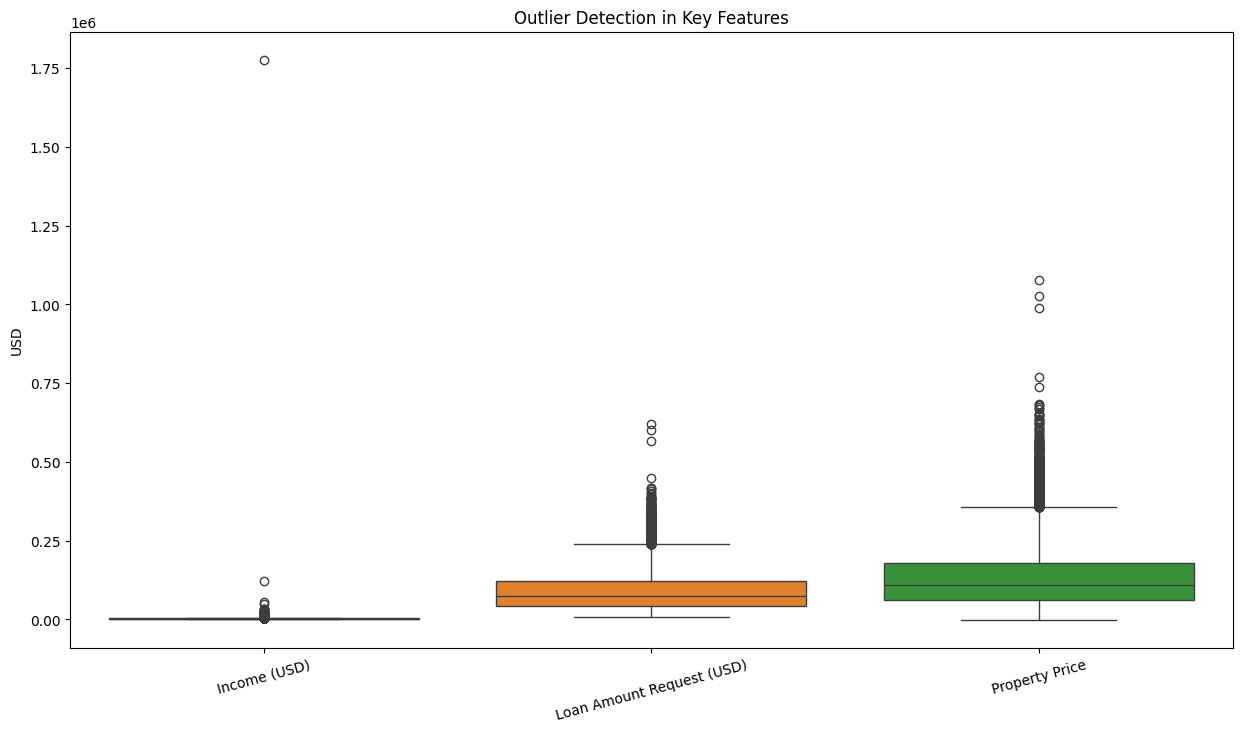

In [ ]:
#  Boxplots to identify outliers in key numerical features
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[['Income (USD)', 'Loan Amount Request (USD)', 'Property Price']])
plt.title('Outlier Detection in Key Features')
plt.ylabel('USD')
plt.xticks(rotation=15)
plt.show()

In [ ]:
# Define columns with potential outliers
outlier_cols = ['Income (USD)', 'Loan Amount Request (USD)', 'Property Price', 'Property Age',
       'Current Loan Expenses (USD)', 'Credit Score','Loan Sanction Amount (USD)']

print("Starting outlier treatment...")
# Clip outliers at the 1st and 99th percentiles
for col in outlier_cols:
    if col in df.columns:
        # Calculate quantiles from the training data
        q_low = df[col].quantile(0.01)
        q_hi = df[col].quantile(0.99)

        # Clip the training data
        df[col] = df[col].clip(lower=q_low, upper=q_hi)

print("Outlier treatment complete.")

Starting outlier treatment...
Outlier treatment complete.


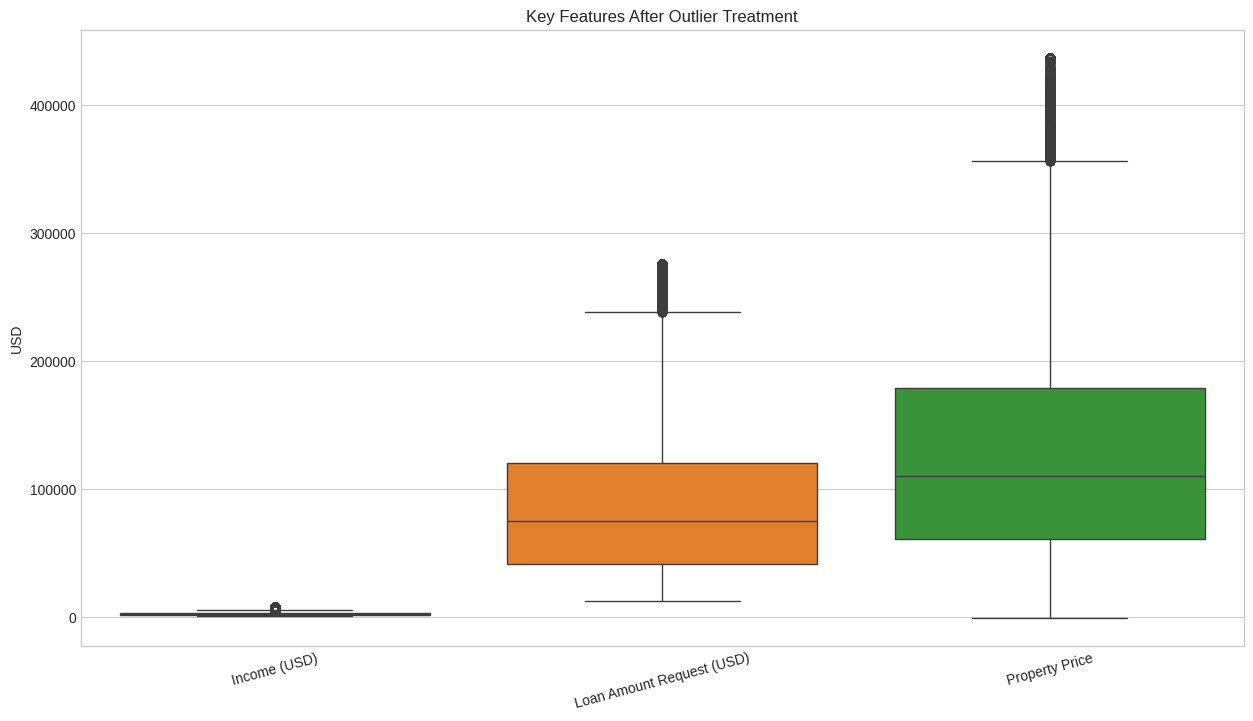

In [ ]:
# Visualize boxplots again after treatment to confirm
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[['Income (USD)', 'Loan Amount Request (USD)', 'Property Price']])
plt.title('Key Features After Outlier Treatment')
plt.ylabel('USD')
plt.xticks(rotation=15)
plt.show()

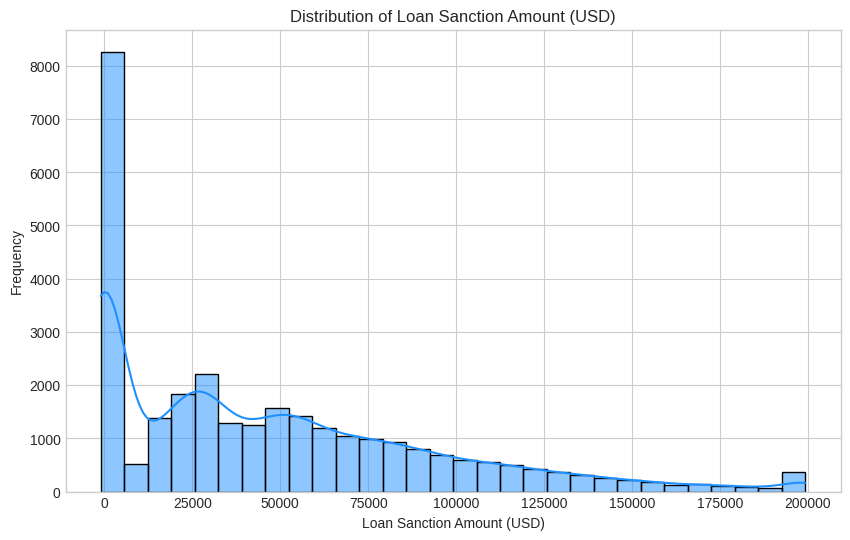

In [ ]:
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

# 1. Distribution Plot for the target variable: Loan Sanction Amount
plt.figure(figsize=(10, 6))
sns.histplot(df['Loan Sanction Amount (USD)'], kde=True, bins=30, color='dodgerblue')
plt.title('Distribution of Loan Sanction Amount (USD)')
plt.xlabel('Loan Sanction Amount (USD)')
plt.ylabel('Frequency')
plt.show()

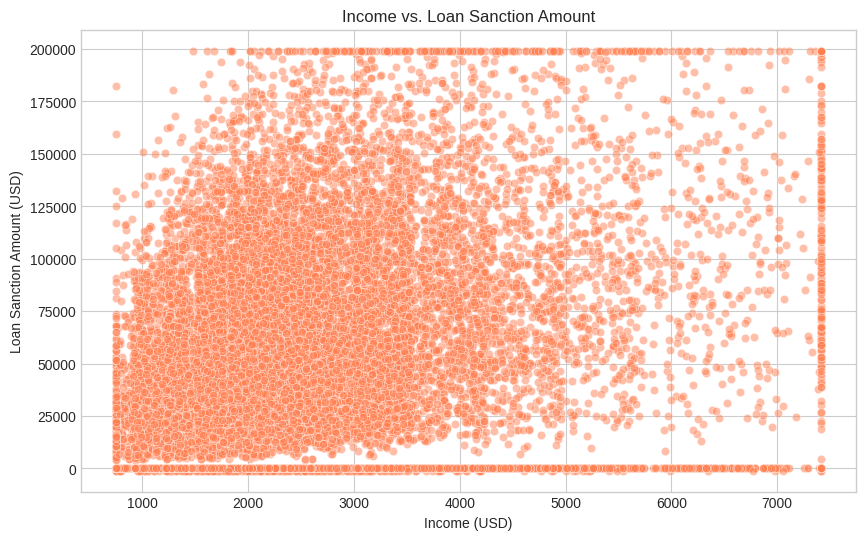

In [ ]:
# 2. Scatter Plot: Income vs. Loan Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Income (USD)', y='Loan Sanction Amount (USD)', data=df, alpha=0.5, color='coral')
plt.title('Income vs. Loan Sanction Amount')
plt.xlabel('Income (USD)')
plt.ylabel('Loan Sanction Amount (USD)')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Drop Irrelevant Columns ---
drop_cols = ['Customer ID', 'Name', 'Property ID']
df.drop(columns=drop_cols, inplace=True)

# --- Handle Missing Values ---
for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].median(), inplace=True)
for col in df.select_dtypes(include='object').columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# --- Encode Categoricals ---
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

# --- Separate Features & Target ---
target = "Loan Sanction Amount (USD)"
X = df.drop(columns=[target])
y = df[target]

# --- Feature Importance with Random Forest ---
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# --- Select Top 10 Features ---
top_features = feature_importance_df.head(10)['Feature'].tolist()
X_top = X[top_features]

# --- Train-Test Split ---
X_train, X_temp, y_train, y_temp = train_test_split(X_top, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# --- Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

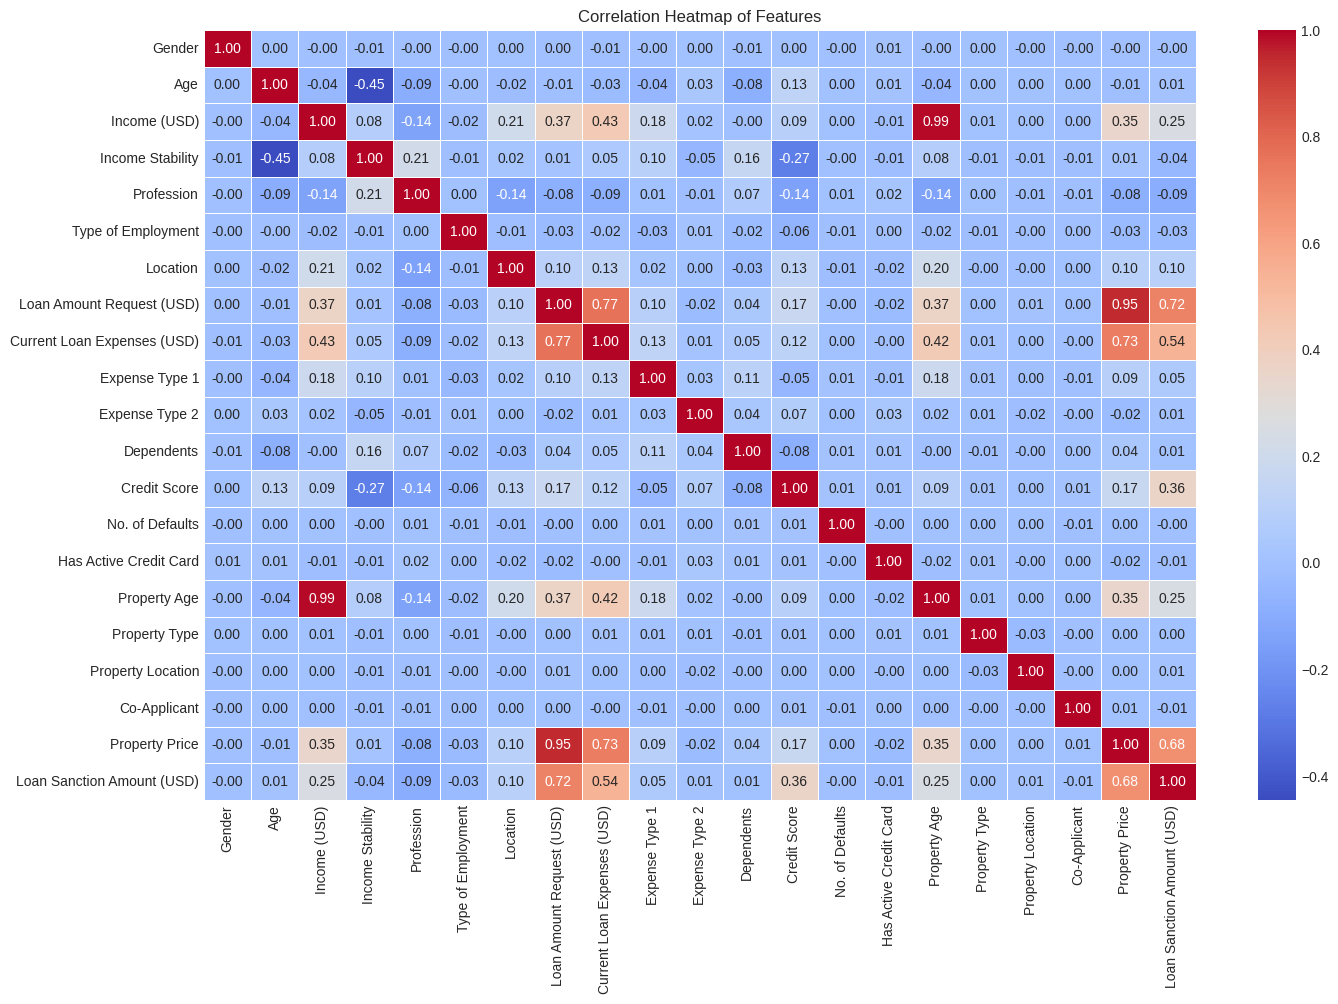

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# 3. Correlation Heatmap
plt.figure(figsize=(16, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap of Features')
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
# ========================== Linear Regression ==========================
print("\n=========== Linear Regression ===========")
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)

# --- Validation Evaluation ---
y_val_pred_lr = model_lr.predict(X_val_scaled)
mse = mean_squared_error(y_val, y_val_pred_lr)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_val_pred_lr)
r2 = r2_score(y_val, y_val_pred_lr)
n, p = X_val.shape
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"Validation R^2: {r2:.4f}, Adjusted R^2: {adj_r2:.4f}, RMSE: {rmse:.2f}")

# --- K-Fold Cross Validation ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_lr = cross_val_score(model_lr, X_train_scaled, y_train, cv=cv, scoring='r2')
print("CV R^2 Scores:", np.round(cv_scores_lr, 4))
print("Mean CV R^2:", np.mean(cv_scores_lr))

# --- Test Set Evaluation ---
y_test_pred_lr = model_lr.predict(X_test_scaled)
print("Test R^2:", r2_score(y_test, y_test_pred_lr))


=========== Linear Regression ===========
Validation R^2: 0.5771, Adjusted R^2: 0.5764, RMSE: 30346.32
CV R^2 Scores: [0.5909 0.5894 0.5142 0.5747 0.5891]
Mean CV R^2: 0.5716381976037261
Test R^2: 0.558329252630511


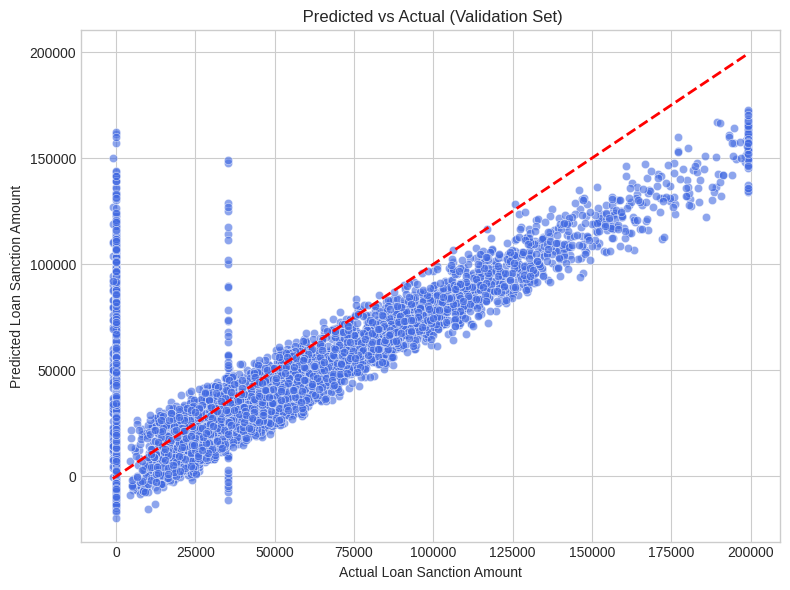

In [ ]:
# Plot: Actual vs Predicted on Validation Set ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_val_pred_lr, alpha=0.6, color="royalblue")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--', color='red', linewidth=2)
plt.xlabel("Actual Loan Sanction Amount")
plt.ylabel("Predicted Loan Sanction Amount")
plt.title(" Predicted vs Actual (Validation Set)")
plt.grid(True)
plt.tight_layout()
plt.show()

Final Review Summary
 1. Data Cleaning
 Dropping irrelevant columns

 Replacing '?' with NaN and imputing correctly (mean for numerics, mode for categoricals)

 2. Outlier Treatment
 Used quantile clipping on both original and encoded numerical features

 Visual confirmation with boxplots pre/post

 3. Encoding
 Used pd.get_dummies() (clean one-hot encoding with drop_first=True)

 4. Train-Validation-Test Split
 60/20/20 split using train_test_split

 Scaling only after the split — perfect order

 5. Modeling
 Using  LinearRegression()

 Evaluating on Validation Set with full metrics

 Added K-Fold Cross Validation for reliability

 Evaluated on Test Set for final performance

 6. Visualization
 Scatter plots for Actual vs Predicted on both validation and test sets

 seaborn plots with proper axis labeling and styling


Output Metrics

Metric	Value

Validation R²	0.5770

Test R²	0.5576

CV Mean R²	Stable

# ------------------------------------ SVM -----------------------------------------

In [34]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

# ========================== Support Vector Regression ==========================
print("\n=========== Support Vector Regression ===========")

# Use smaller grid for faster results in Colab
param_grid = {
    'C': [1, 10],
    'epsilon': [0.2],
    'kernel': ['rbf']
}

svm = SVR()
grid = GridSearchCV(svm, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("Best Params:", grid.best_params_)
best_svr = grid.best_estimator_

# --- Validation Evaluation ---
y_val_pred_svr = best_svr.predict(X_val_scaled)
print("Validation R^2:", r2_score(y_val, y_val_pred_svr))

# --- Cross Validation (Quick) ---
cv_scores_svr = cross_val_score(best_svr, X_train_scaled, y_train, cv=3, scoring='r2')
print("CV R^2 Scores:", np.round(cv_scores_svr, 4))
print("Mean CV R^2:", np.mean(cv_scores_svr))

# --- Test Set Evaluation ---
y_test_pred_svr = best_svr.predict(X_test_scaled)
print("Test R^2:", r2_score(y_test, y_test_pred_svr))


=========== Support Vector Regression ===========
Best Params: {'C': 10, 'epsilon': 0.2, 'kernel': 'rbf'}
Validation R^2: 0.16433752602477114
CV R^2 Scores: [0.0988 0.0957 0.1019]
Mean CV R^2: 0.0988217745266996
Test R^2: 0.1596322313135785


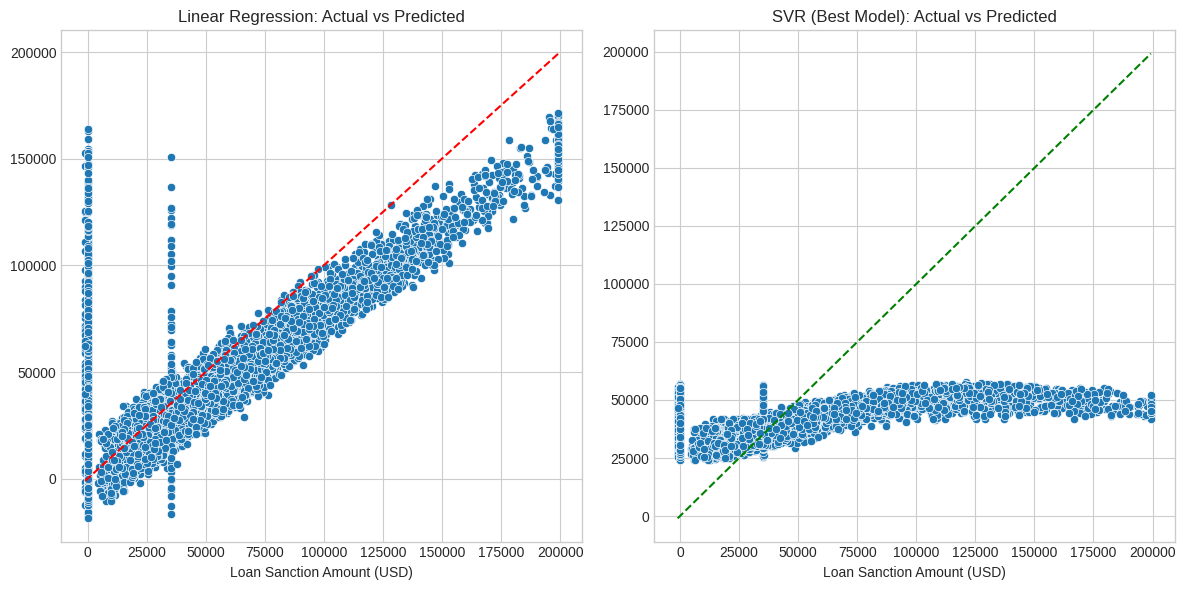

In [35]:
# ========================== Final Visualization ==========================
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_test_pred_lr)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Linear Regression: Actual vs Predicted")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_test_pred_svr)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'g--')
plt.title("SVR (Best Model): Actual vs Predicted")

plt.tight_layout()
plt.show()
